# Librerias

In [1]:
import os
import pyodbc
import glob
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import pandas as pd
import itertools
from sklearn.metrics import r2_score
import pyodbc

# Para quitar unos warnings
warnings.filterwarnings("ignore", message="pandas only supports SQLAlchemy connectable")

# Regresión Lineal Variable Churn

La consulta `regresion_cliente` está diseñada para calcular una serie de métricas agregadas en función del **PVP**. Se utiliza el PVP como índice para analizar cómo varían ciertas características del cliente y del vehículo en relación con este. 

El objetivo principal es **estimar el Churn (tasa de abandono)**. Para ello, primero se extraen métricas agregadas que pueden estar relacionadas con el comportamiento de compra y mantenimiento del vehículo. Posteriormente, se analizará cuáles de estas métricas tienen mayor correlación con el Churn para seleccionar las más relevantes.

Una vez identificadas las variables más significativas, se aplicará un **modelo de regresión lineal** para estimar el **Churn Medio**, es decir, la probabilidad de que un cliente abandone.

## Consulta Regresion Cliente

Aunque,para poder revisar más a fondo la consulta, esta se encuentra en `queries/vision_cliente.sql`.
Las variables que hemos calculado por PVP son las que mostramos a continuación.

**Variables de la Consulta**

- *PVP*
- *Numero_Compras*
- *Edad_Media_Cliente*
- *Edad_Media_Coche*
- *Margen_Bruto_Medio*
- *Margen_Eur_Medio*
- *Coste_Total*
- *Renta_Media*
- *Km_medio_por_revision*
- *Revisiones_Medias*
- *Coste_Venta_No_Impuestos_Medio*
- *Dias_En_Taller*
- *Churn_Medio* (Variable objetivo)


**Creación tabla en SSMS**

In [2]:
# Conexión a SQL Server Local
LOCAL_SERVER = 'localhost'
LOCAL_DATABASE = 'dwh_case1'
LOCAL_DRIVER = '{ODBC Driver 17 for SQL Server}'
local_conn_str = f"DRIVER={LOCAL_DRIVER};SERVER={LOCAL_SERVER};DATABASE={LOCAL_DATABASE};Trusted_Connection=yes;TrustServerCertificate=yes"

conn_local = pyodbc.connect(local_conn_str)

# Leer la consulta desde la carpeta "queries"
BASE_DIR = os.getcwd()
queries_path = os.path.join(BASE_DIR, "..", "queries")
regresion_file = os.path.join(queries_path, "regresion_cliente.sql")
with open(regresion_file, 'r', encoding='utf-8') as file:
    regresion_query = file.read()

# Ejecutar la consulta y guardar en DataFrame
df_reg = pd.read_sql(regresion_query, conn_local)
print(f"Filas extraídas para regresión: {df_reg.shape[0]}")
print("Columnas extraídas:", ', '.join(list(df_reg.columns)))

conn_local.close()


Filas extraídas para regresión: 1011
Columnas extraídas: PVP, Numero_Compras, Edad_Media_Cliente, Edad_Media_Coche, Margen_Bruto_Medio, Margen_Eur_Medio, Coste_Total, Renta_Media, Km_medio_por_revision, Revisiones_Medias, Coste_Venta_No_Impuestos_Medio, Dias_En_Taller, churn_medio


In [3]:
df_reg

,PVP,Numero_Compras,Edad_Media_Cliente,Edad_Media_Coche,Margen_Bruto_Medio,Margen_Eur_Medio,Coste_Total,Renta_Media,Km_medio_por_revision,Revisiones_Medias,Coste_Venta_No_Impuestos_Medio,Dias_En_Taller,churn_medio
0,10528,174,42,2.057471,2947.840088,1420.462045,1527.377921,23566,17630,0,435,1.327586,0.563218
1,10909,162,41,2.314815,3054.520020,1676.102518,1378.417502,22945,14328,0,255,3.987654,0.654320
2,11004,239,43,2.054393,3081.120117,1755.825153,1325.294842,23215,16105,0,194,0.974895,0.518828
3,11100,2,47,3.500000,3108.000000,1720.000000,1388.000000,29759,39937,2,250,0.000000,1.000000
4,11237,89,44,2.089888,3146.360107,1197.343844,1949.016141,23823,18348,0,800,0.955056,0.550561
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,36496,29,42,2.448276,12043.679688,360.542077,11683.137931,17480,7966,0,2309,1.586207,0.551724
1007,36634,329,42,2.118541,15752.620117,13577.761098,2174.859329,17932,7552,0,1192,1.340426,0.559270
1008,36771,122,40,2.188525,15811.530273,13651.938220,2159.592122,17215,9650,0,1174,2.237705,0.532786
1009,37832,12,42,2.416667,12484.559570,213.310008,12271.250000,15680,7322,0,2563,0.416667,0.583333


## Correlación Variables con Churn

En la siguiente matriz estudiamos la correlación de todas las variables que hemos seleccionado con la objetivo que es `churn_medio`.

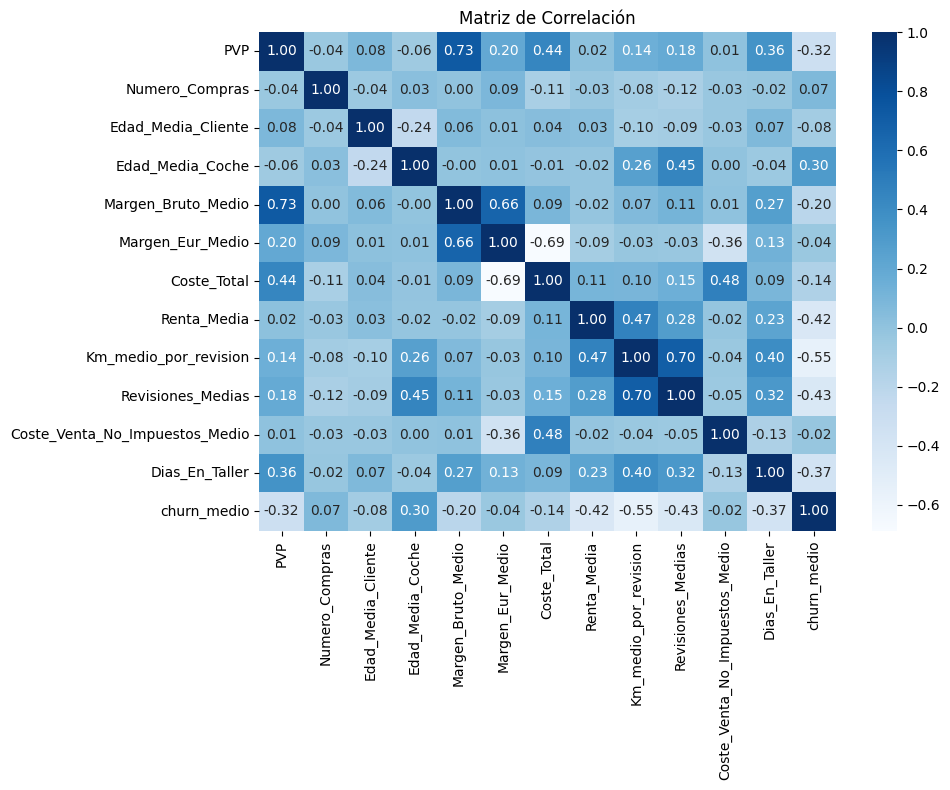

In [4]:
corr_matrix = df_reg.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="Blues", fmt=".2f")
plt.title("Matriz de Correlación")
plt.tight_layout()
plt.show()


**Variables Seleccionadas para la Regresión y su Impacto en Churn Medio**

Las siguientes variables han sido seleccionadas para la regresión debido a su relación con **Churn**. A continuación, se presentan sus coeficientes de correlación con esta variable y una posible interpretación:

1. `PVP (Precio de Venta al Público)` (-0.32)  
   - Un coeficiente negativo indica que a mayor precio de compra, menor es la tasa de abandono. Esto sugiere que los clientes que adquieren vehículos más caros tienen mayor compromiso con la marca y es menos probable que abandonen.

2. `Edad_Media_Coche` (0.30)  
   - Un coeficiente positivo implica que, a medida que aumenta la edad media del coche comprado, también aumenta la probabilidad de que el cliente abandone. Esto puede deberse a que los clientes con coches más antiguos buscan opciones en otros concesionarios.


3. `Revisiones_Medias`(-0.43): 
   - Existe una relación negativa moderada con la tasa de abandono. Esto indica que los clientes que realizan más revisiones suelen tener menor probabilidad de churn.

4. `Km_medio_por_revision` (-0.55)  
   - Un coeficiente negativo elevado indica que a mayor número de kilómetros recorridos entre revisiones, menor es la tasa de abandono. Esto puede interpretarse como una mayor dependencia del cliente en los servicios del concesionario, reduciendo su probabilidad de churn.



## EDA

**Histogramas**

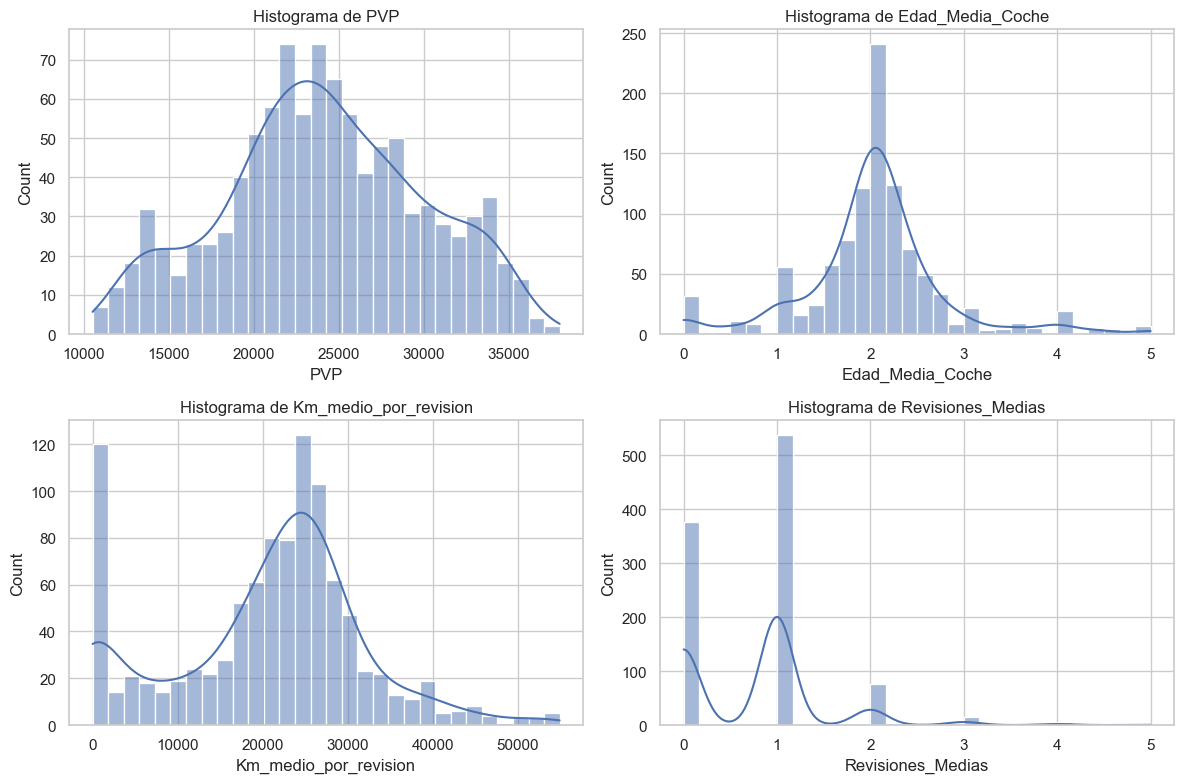

In [5]:
variables_seleccionadas = ['PVP', 'Edad_Media_Coche', 'Km_medio_por_revision', 'Revisiones_Medias']

sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, var in enumerate(variables_seleccionadas):
    sns.histplot(df_reg[var], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Histograma de {var}')

plt.tight_layout()
plt.show()


*Puntos a recalcar*:
- Los Km Medios  por Revisión en 0 sugieren que esos clientes no han realizado ninguna revisión en el concesionario.

**Gráficos Dispersión**

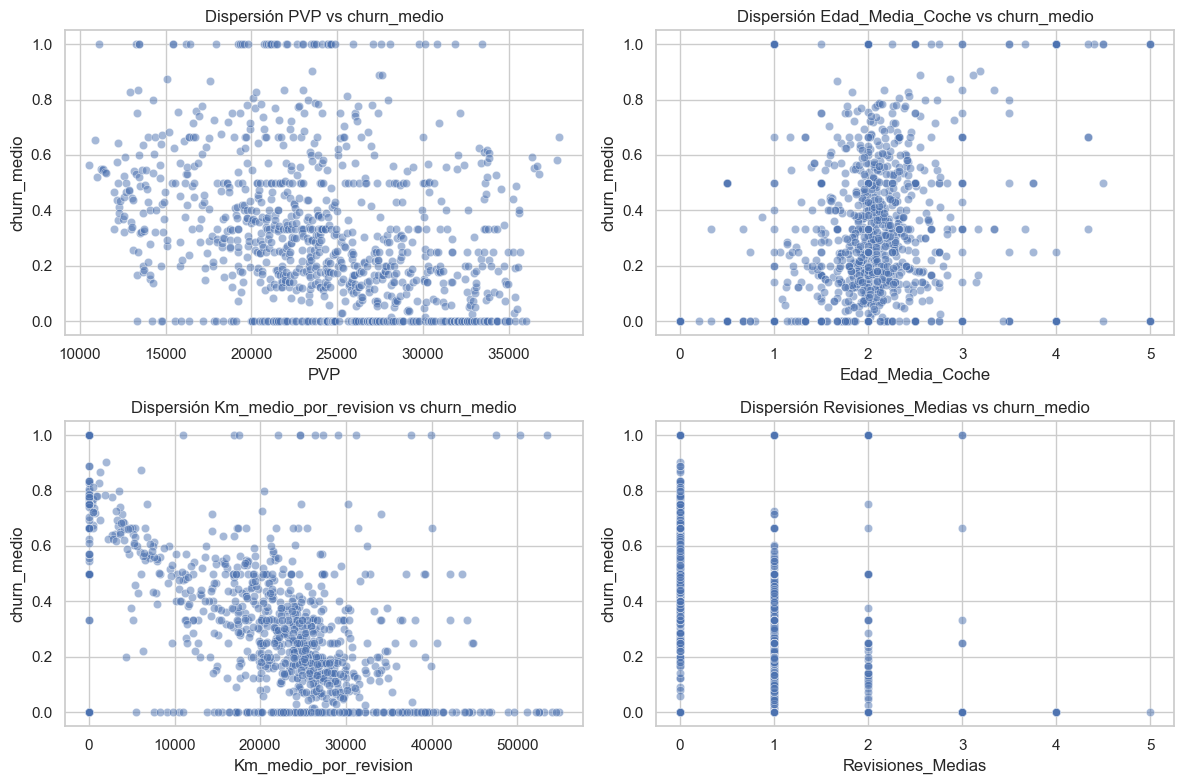

In [6]:
# Crear gráficos de dispersión entre churn_medio y las variables seleccionadas
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, var in enumerate(variables_seleccionadas):
    sns.scatterplot(x=df_reg[var], y=df_reg['churn_medio'], alpha=0.5, ax=axes[i])
    axes[i].set_title(f'Dispersión {var} vs churn_medio')

plt.tight_layout()
plt.show()

*Puntos a Recalcar*
- Kilómetros Medios por Revisión vs Churn:

   - Hay una clara tendencia descendente, es decir, a medida que los clientes realizan más kilómetros antes de la revisión, el Churn Medio tiende a reducirse.

   - Se observa que los clientes con Km_medio_por_revision cercanos a 0 tienen valores altos de Churn, lo que puede indicar que aquellos que no hacen revisiones son más propensos a abandonar.

- Revisiones Medias vs Churn:
   - Se observa que los clientes con pocas o ninguna revisión tienen una mayor dispersión en churn, mientras que los que han hecho revisiones presentan menor churn.

- PVP y Edad_Media_Coche tienen una relación menos evidente, aunque pueden influir en combinación con otras variable



## Regresión Lineal

El objetivo de este análisis es entrenar regresiones lineales utilizando diferentes combinaciones de 4 variables para predecir la variable Churn Medio. Se selecciona la combinación con el **mayor R²**, ya que esto indica que el modelo explica mejor la variabilidad de la variable dependiente (Churn Medio).

In [7]:
# Variables candidatas
variables = ['PVP', 'Numero_Compras', 'Edad_Media_Cliente', 'Edad_Media_Coche',
       'Margen_Bruto_Medio', 'Margen_Eur_Medio', 'Coste_Total', 'Renta_Media',
       'Km_medio_por_revision', 'Revisiones_Medias',
       'Coste_Venta_No_Impuestos_Medio', 'Dias_En_Taller']

objetivo = "churn_medio"
resultados = []

combinaciones = list(itertools.combinations(variables, 4))

for vars_comb in combinaciones:
    X = df_reg[list(vars_comb)]
    y = df_reg[objetivo]

    modelo = LinearRegression()
    modelo.fit(X, y)
    y_pred = modelo.predict(X)

    r2 = r2_score(y, y_pred)
    resultados.append((vars_comb, r2))

# Mostrar las mejores combinaciones ordenadas por R²
resultados.sort(key=lambda x: x[1], reverse=True)

print("Ranking de combinaciones por R²:\n")
for i, (vars_comb, r2) in enumerate(resultados[:5], 1):
    print(f"{i}. Variables: {vars_comb} → R²: {r2:.4f}")


Ranking de combinaciones por R²:

1. Variables: ('PVP', 'Edad_Media_Coche', 'Km_medio_por_revision', 'Revisiones_Medias') → R²: 0.6098
2. Variables: ('Edad_Media_Coche', 'Margen_Bruto_Medio', 'Km_medio_por_revision', 'Revisiones_Medias') → R²: 0.6019
3. Variables: ('Edad_Media_Coche', 'Renta_Media', 'Km_medio_por_revision', 'Revisiones_Medias') → R²: 0.5978
4. Variables: ('Edad_Media_Coche', 'Margen_Eur_Medio', 'Km_medio_por_revision', 'Revisiones_Medias') → R²: 0.5903
5. Variables: ('Edad_Media_Coche', 'Km_medio_por_revision', 'Revisiones_Medias', 'Coste_Venta_No_Impuestos_Medio') → R²: 0.5892


**Selección mejor Regresión Lineal**

Este código selecciona automáticamente la mejor combinación de 4 variables entre las posibles para predecir la variable dependiente churn_medio utilizando una regresión lineal

In [8]:
# Lista de todas las variables posibles
variables = ['PVP', 'Numero_Compras', 'Edad_Media_Cliente', 'Edad_Media_Coche',
       'Margen_Bruto_Medio', 'Margen_Eur_Medio', 'Coste_Total', 'Renta_Media',
       'Km_medio_por_revision', 'Revisiones_Medias',
       'Coste_Venta_No_Impuestos_Medio', 'Dias_En_Taller']

#Inicializar parámetros
best_r2 = -1
best_combination = None

# Probar todas las combinaciones de 4 variables
for comb in itertools.combinations(variables, 4):
    X = df_reg[list(comb)]  
    y = df_reg['churn_medio']  

  
    model = LinearRegression()
    model.fit(X, y)

    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    if r2 > best_r2:
        best_r2 = r2
        best_combination = comb



print("Mejor combinación de variables:", best_combination)
print("Mejor R²:", best_r2)

Mejor combinación de variables: ('PVP', 'Edad_Media_Coche', 'Km_medio_por_revision', 'Revisiones_Medias')
Mejor R²: 0.6098117830886592


**Entrenamiento del modelo**

A continuación, se va a expresar la variable `churn` en función de las variables seleccionadas en la regresión lineal. El modelo de regresión lineal tiene la siguiente forma:

$
\text{churn} = \text{intercepto} + a_1 \cdot \text{variable}_1 + a_2 \cdot \text{variable}_2 + a_3 \cdot \text{variable}_3 + a_4 \cdot \text{variable}_4
$

In [9]:
X_best = df_reg[list(best_combination)]  # Variables con la mejor combinación
y_best = df_reg['churn_medio']  

model = LinearRegression()
model.fit(X_best, y_best)

# Mostrar los coeficientes y el intercepto del modelo
coeficientes = model.coef_
intercepto = model.intercept_

print("Coeficientes:")
for i, col in enumerate(best_combination):
    print(f"{col}: {coeficientes[i]}")

print(f"Intercepto: {intercepto}")

Coeficientes:
PVP: -7.222052719466824e-06
Edad_Media_Coche: 0.195980999667167
Km_medio_por_revision: -9.97713691569535e-06
Revisiones_Medias: -0.13296948739772288
Intercepto: 0.40638941827302555


## Guardar los coeficientes Regresión SSMS

Los coeficientes obtenidos en la regresión lineal se han almacenado en una tabla en SSMS.
Esto permite que puedan ser utilizados posteriormente en cálculos como la estimación del Churn Medio, la Retención y el CLV,

In [10]:
# Conexión a SQL Server Local
LOCAL_SERVER = 'localhost'  # Servidor local
LOCAL_DATABASE = 'dwh_case1'  # Base de datos local
LOCAL_DRIVER = '{ODBC Driver 17 for SQL Server}'

# Cadena de conexión para SQL Server local
local_conn_str = f"DRIVER={LOCAL_DRIVER};SERVER={LOCAL_SERVER};DATABASE={LOCAL_DATABASE};Trusted_Connection=yes;TrustServerCertificate=yes"

# Conectar a SQL Server Local
conn_local = pyodbc.connect(local_conn_str)
cursor_local = conn_local.cursor()


In [11]:
coeficientes = model.coef_
intercepto = model.intercept_
variables = best_combination

# Crear DataFrame con resultados
df_resultados = pd.DataFrame({
    'Variable': list(variables) + ['Intercepto'],
    'Valor': list(coeficientes) + [intercepto]
})

df_resultados

,Variable,Valor
0,PVP,-0.000007
1,Edad_Media_Coche,0.195981
2,Km_medio_por_revision,-0.000010
3,Revisiones_Medias,-0.132969
4,Intercepto,0.406389


In [ ]:
try:
    conn_local = pyodbc.connect(local_conn_str)
    cursor = conn_local.cursor()

    # Eliminar tabla si ya existe
    cursor.execute("DROP TABLE IF EXISTS Regresion_Coeficientes")
    conn_local.commit()

    # Crear tabla
    create_table_sql = """
    CREATE TABLE Regresion_Coeficientes (
        Variable NVARCHAR(255),
        Valor FLOAT
    );
    """
    cursor.execute(create_table_sql)
    conn_local.commit()

    # Insertar resultados
    insert_sql = "INSERT INTO Regresion_Coeficientes (Variable, Valor) VALUES (?, ?)"
    cursor.fast_executemany = True
    cursor.executemany(insert_sql, df_resultados.values.tolist())
    conn_local.commit()

    print("✅ Tabla Regresion_Coeficientes creada e insertada correctamente.")

except Exception as e:
    print(f" Error: {e}")

finally:
    if 'conn_local' in locals():
        conn_local.close()

✅ Tabla Regresion_Coeficientes creada e insertada correctamente.


# Tabla Final BI

**Paso 1: Obtener los coeficientes de la regresión**

Los coeficientes de la regresión lineal que hemos obtenido previamente se almacenan en la tabla Regresion_Coeficientes dentro de SQL Server. Estos coeficientes representan la relación entre las variables explicativas y la variable objetivo (`churn_medio`). Se extraen y se utilizan para calcular nuevas métricas.


**Paso 2: Aplicación del Modelo a los Datos de Cliente**
Usando los coeficientes obtenidos, aplicamos la ecuación de regresión a los datos de cada cliente en la tabla vision_cliente. En este proceso, se calculan:

- Churn Medio Estimado: Probabilidad de que un cliente abandone.
- Retención:1 -Churn.
- CLV a 5 años: Estimación del valor económico de un cliente en el futuro.

**Paso 3: Normalización de los Resultados**

Dado que la regresión lineal puede generar valores fuera del rango [0,1], se aplica una transformación con las funciones `GREATEST(0, ...)` y `LEAST(1, ...)` para garantizar que los valores sean interpretables y realistas.

**Paso 4: Creación de la Tabla bi_cliente**

Los resultados obtenidos se almacenan en una nueva tabla llamada bi_cliente, la cual contiene todas las variables originales de vision_cliente junto con los nuevos cálculos (`churn_medio_estimado`, `retención` y `CLV_5_anos`). Esta tabla permite analizar el comportamiento de los clientes y su valor futuro.


In [18]:
# Conexión SQL Server Local
LOCAL_SERVER = 'localhost'
LOCAL_DATABASE = 'dwh_case1'
LOCAL_DRIVER = '{ODBC Driver 17 for SQL Server}'
local_conn_str = f"DRIVER={LOCAL_DRIVER};SERVER={LOCAL_SERVER};DATABASE={LOCAL_DATABASE};Trusted_Connection=yes;TrustServerCertificate=yes"

# Conectar a la base de datos
conn_local = pyodbc.connect(local_conn_str)
cursor_local = conn_local.cursor()

# Obtener coeficientes de la regresión desde SQL Server
query_coef = """
SELECT 
    MAX(CASE WHEN Variable = 'Intercepto' THEN Valor END) AS b0,
    MAX(CASE WHEN Variable = 'PVP' THEN Valor END) AS b1,
    MAX(CASE WHEN Variable = 'Edad_Media_Coche' THEN Valor END) AS b2,
    MAX(CASE WHEN Variable = 'Km_medio_por_revision' THEN Valor END) AS b3,
    MAX(CASE WHEN Variable = 'Revisiones_Medias' THEN Valor END) AS b4
FROM [dwh_case1].[dbo].[Regresion_Coeficientes];
"""

cursor_local.execute(query_coef)
coeficientes = cursor_local.fetchone()
cursor_local.close() 

# Validar si se encontraron coeficientes
if coeficientes is None or None in coeficientes:
    print("Error: No se encontraron coeficientes válidos en la tabla 'Regresion_Coeficientes'.")
    conn_local.close()
    exit()

b0, b1, b2, b3, b4 = coeficientes  # Extraer valores numéricos

# Ejecutar la consulta principal
query = f"""
SELECT 
    vc.*, 
    -- Churn y retención limitados entre [0,1]
    GREATEST(0, LEAST(1, ({b0} + {b1} * vc.PVP_Medio + {b2} * vc.Edad_Media_Coche 
        + {b3} * vc.Km_Medio_por_Revision + {b4} * vc.Total_Revisiones))) AS churn_medio_estimado,

    GREATEST(0, LEAST(1, (1 - ({b0} + {b1} * vc.PVP_Medio + {b2} * vc.Edad_Media_Coche 
        + {b3} * vc.Km_Medio_por_Revision + {b4} * vc.Total_Revisiones)))) AS retencion,

    -- CLV a 5 años
    vc.Margen_eur_Medio * (
        POWER(GREATEST(0, LEAST(1, 1 - ({b0} + {b1} * vc.PVP_Medio + {b2} * vc.Edad_Media_Coche 
        + {b3} * vc.Km_Medio_por_Revision + {b4} * vc.Total_Revisiones))), 1) / POWER(1.07, 1) +
        POWER(GREATEST(0, LEAST(1, 1 - ({b0} + {b1} * vc.PVP_Medio + {b2} * vc.Edad_Media_Coche 
        + {b3} * vc.Km_Medio_por_Revision + {b4} * vc.Total_Revisiones))), 2) / POWER(1.07, 2) +
        POWER(GREATEST(0, LEAST(1, 1 - ({b0} + {b1} * vc.PVP_Medio + {b2} * vc.Edad_Media_Coche 
        + {b3} * vc.Km_Medio_por_Revision + {b4} * vc.Total_Revisiones))), 3) / POWER(1.07, 3) +
        POWER(GREATEST(0, LEAST(1, 1 - ({b0} + {b1} * vc.PVP_Medio + {b2} * vc.Edad_Media_Coche 
        + {b3} * vc.Km_Medio_por_Revision + {b4} * vc.Total_Revisiones))), 4) / POWER(1.07, 4) +
        POWER(GREATEST(0, LEAST(1, 1 - ({b0} + {b1} * vc.PVP_Medio + {b2} * vc.Edad_Media_Coche 
        + {b3} * vc.Km_Medio_por_Revision + {b4} * vc.Total_Revisiones))), 5) / POWER(1.07, 5)
    ) AS CLV_5_anos
FROM dwh_case1.dbo.vision_cliente vc;
"""

df = pd.read_sql(query, conn_local)

# Eliminar la columna 'churn_medio' si existe en el DataFrame
if 'Churn_Cliente' in df.columns:
    df = df.drop(columns=['Churn_Cliente'])


# Crear la tabla 'bi_cliente' en SQL Server Local (eliminar si existe)
cursor_local = conn_local.cursor()
cursor_local.execute("DROP TABLE IF EXISTS bi_cliente")
conn_local.commit()

# Crear la tabla con los tipos de datos correctos
create_table_sql = f"""
CREATE TABLE bi_cliente (
    {', '.join([
        f'[{col}] FLOAT' if df[col].dtype == 'float32'
        else f'[{col}] INT' if df[col].dtype == 'int32'
        else f'[{col}] NVARCHAR(255)' for col in df.columns
    ])}
);
"""
cursor_local.execute(create_table_sql)
conn_local.commit()

print("\n- Tabla 'bi_cliente' creada correctamente en SQL Server Local.")

# Insertar los datos en la tabla
placeholders = ', '.join(['?' for _ in df.columns])
insert_sql = f"INSERT INTO bi_cliente VALUES ({placeholders})"

cursor_local.fast_executemany = True
cursor_local.executemany(insert_sql, df.values.tolist())
conn_local.commit()

# Mostrar resumen final
print("\nTabla: bi_cliente")
print(f" Columnas extraídas: {df.shape[1]}")
print(f" Filas extraídas: {df.shape[0]}")
print(" Tabla eliminada (si existía): Sí")
print(" Tabla creada: Sí")
print(f" Filas insertadas: {df.shape[0]}")

# Cerrar conexiones
cursor_local.close()
conn_local.close()

print("\nDatos extraídos, guardados y cargados en SQL Server correctamente.")



- Tabla 'bi_cliente' creada correctamente en SQL Server Local.

Tabla: bi_cliente
 Columnas extraídas: 39
 Filas extraídas: 44053
 Tabla eliminada (si existía): Sí
 Tabla creada: Sí
 Filas insertadas: 44053

Datos extraídos, guardados y cargados en SQL Server correctamente.


**Interpretación Clave**

- Como hemos tenido que ajustar los datos como comentamos,no nos debe extrañar que haya algunos valores de CLV=0.Puesto que, aquellos val0roes cuya retención sea <0 (transformados a 0) nos darán CLV nulo.

- También es importante recalcar que aquellos CLV<0 están asociados a aquellos clientes con los cuales la marca de coches esté perdidiendo ya dinero directamente  Margen_eur de estos es <0.

Finalmente, nos guardamos el archivo para el análisis:

In [24]:
if 'Churn_Cliente' in df.columns:
    df = df.drop(columns=['Churn_Cliente'])

df.to_csv("cliente_bi.csv", index=False, encoding='utf-8')